# A discrimination experiment

In [1]:
%%writefile ../files/psychopy_discrimination.py

#!/usr/bin/env python
"""

Using psychopy to perform an experiment on discriminating clouds

(c) Laurent Perrinet - INT/CNRS & Jonathan Vacher - CeReMaDe

"""
# width and height of your screen
w, h = 1920, 1200
w, h = 2560, 1440 # iMac 27''

# width and height of the stimulus
w_stim, h_stim = 1024, 1024


print('launching experiment')
from psychopy import visual, core, event, logging, misc
logging.console.setLevel(logging.DEBUG)

import os, numpy
import MotionClouds as mc
import time, datetime

#if no file use some defaults
info = {}
info['observer'] = 'anonymous'
info['screen_width'] = w
info['screen_height'] = h
info['nTrials'] = 50
info['N_X'] = mc.N_X # size of image
info['N_Y'] = mc.N_Y # size of image
info['N_frame_total'] = 32 # a full period. in time frames
info['N_frame'] = 32 # length of the presented period. in time frames
info['timeStr'] = datetime.datetime.now().date().isoformat() + time.strftime("_%H%M", time.localtime())

fileName = 'data/discriminating_v2_' + info['observer'] + '_' + info['timeStr'] + '.pickle'

print('generating data')

alphas = [-1., -.5, 0., 0.5, 1., 1.5, 2.]
fx, fy, ft = mc.get_grids(info['N_X'], info['N_Y'], info['N_frame_total'])
slows = [2*mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, V_Y=0., V_X = 1.1, B_sf = 10., alpha=alpha))) - 1 for alpha in alphas]
fasts = [2*mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, V_Y=0., V_X = 0.9, B_sf = 10., alpha=alpha))) - 1 for alpha in alphas]

print('go!      ')
win = visual.Window([info['screen_width'], info['screen_height']], fullscr=True)

stimLeft = visual.GratingStim(win, 
                            size=(info['screen_width']/2, info['screen_width']/2), 
                            pos=(-info['screen_width']/4, 0), 
                            units='pix',
                            interpolate=True,
                            mask = 'gauss',
                            autoLog=False)#this stim changes too much for autologging to be useful

stimRight = visual.GratingStim(win, 
                            size=(info['screen_width']/2, info['screen_width']/2), 
                            pos=(info['screen_width']/4, 0), 
                            units='pix',
                            interpolate=True,
                            mask = 'gauss',
                            autoLog=False)#this stim changes too much for autologging to be useful

wait_for_response = visual.TextStim(win, 
                        text = u"?", units='norm', height=0.15, color='DarkSlateBlue',
                        pos=[0., -0.], alignHoriz='center', alignVert='center' ) 
wait_for_next = visual.TextStim(win, 
                        text = u"+", units='norm', height=0.15, color='BlanchedAlmond',
                        pos=[0., -0.], alignHoriz='center', alignVert='center' ) 
                        
def getResponse():
    event.clearEvents()#clear the event buffer to start with
    resp = None#initially
    while 1:#forever until we return a keypress
        for key in event.getKeys():
            #quit
            if key in ['escape', 'q']:
                win.close()
                core.quit()
                return None
            #valid response - check to see if correct
            elif key in ['left', 'right']:
                if key in ['left'] :return 0.
                else: return 1.
            else:
                print "hit LEFT or RIGHT (or Esc) (You hit %s)" %key

clock = core.Clock()
FPS = 50.
def presentStimulus(i_alpha, left):
    """
    Present stimulus
    
    TODO : switch randomly up / down
    
    """
    phase_up = numpy.floor(numpy.random.rand() *(info['N_frame_total']-info['N_frame']))
    phase_down = numpy.floor(numpy.random.rand() *(info['N_frame_total']-info['N_frame']))
    up = numpy.random.randint(2)*2 - 1
    clock.reset()
    for i_frame in range(info['N_frame']): # length of the stimulus
        wait_for_next.draw()
        stimLeft.setTex(left * fasts[i_alpha][:, :, up*i_frame+phase_up]+ (1-left) * slows[i_alpha][:, :, up*i_frame+phase_down])
        stimRight.setTex((1.-left) * fasts[i_alpha][:, :, up*i_frame+phase_up]+ left * slows[i_alpha][:, :, up*i_frame+phase_down])
        stimLeft.draw()
        stimRight.draw()
#        while clock.getTime() < i_frame/FPS:
#            print clock.getTime(), i_frame/FPS
#            print('waiting')
        win.flip()

n_alpha = len(alphas)
results = numpy.zeros((n_alpha, info['nTrials']))
for i_trial in range(info['nTrials']):
    wait_for_next.draw()
    win.flip()
    core.wait(0.5)
    left = numpy.random.randint(2) # a random number between 0 and 1
    i_alpha = numpy.random.randint(n_alpha) # a random number between 0 and 1
    presentStimulus(i_alpha, left)
    wait_for_response.draw()
    win.flip()
    results[i_alpha, i_trial] = 2*(left == getResponse())-1

win.update()
core.wait(0.5)

win.close()

#save data
info['alphas'] = alphas
info['results'] = results
misc.toFile(fileName, info)

core.quit() #quit


Overwriting ../files/psychopy_discrimination.py


In [2]:
%cd ../files
#!python2 psychopy_discrimination.py
%cd ../posts

/Users/laurentperrinet/pool/blog/motionclouds.invibe.net/files
/Users/laurentperrinet/pool/blog/motionclouds.invibe.net/posts


## Analysis of the discrimination experiment

In the ``psychopy_discrimination.py`` script, we implemented an experiment to test whether the overall shape of motion clouds could influence discrimination of speed.

Herein, we analyse the data that was collected over different sessions and try to draw some conclusions.

In [3]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

## Analysis - version 1

In a first version of the experiment, we only stored the results in a numpy file.

In [4]:
!ls  ../files/data/discriminating_*

../files/data/discriminating_john_Jan_23_1515.npy
../files/data/discriminating_lup_Jan_23_1401.npy
../files/data/discriminating_lup_Jan_23_1735.npy
../files/data/discriminating_lup_Jan_24_0914.npy
../files/data/discriminating_lup_Jan_24_0919.npy
../files/data/discriminating_lup_Jan_24_0931.npy
../files/data/discriminating_lup_Jan_24_0937.npy
../files/data/discriminating_v2_anonymous_2015-07-01_1422.pickle
../files/data/discriminating_v2_lup_Feb_07_1409.pickle
../files/data/discriminating_v2_lup_Feb_07_1434.pickle


In [5]:
!ls  ../files/data/

competing_v1_bruno_Dec_14_1210.npy
competing_v1_lup_Dec_12_1003.npy
competing_v1_lup_Dec_12_1013.npy
competing_v1_lup_Dec_14_1201.npy
competing_v1_meduz_Dec_14_1204.npy
competing_v2_anonymous_2015-07-01.npy
competing_v2_anonymous_2015-07-01.pickle
competing_v2_anonymous_2015-07-01_1344.npy
competing_v2_anonymous_2015-07-01_1344.pickle
competing_v2_jean_Sep_03_1536.npy
competing_v2_jean_Sep_03_1536.pickle
competing_v2_laurent_Sep_17_1522.npy
competing_v2_laurent_Sep_17_1522.pickle
discriminating_john_Jan_23_1515.npy
discriminating_lup_Jan_23_1401.npy
discriminating_lup_Jan_23_1735.npy
discriminating_lup_Jan_24_0914.npy
discriminating_lup_Jan_24_0919.npy
discriminating_lup_Jan_24_0931.npy
discriminating_lup_Jan_24_0937.npy
discriminating_v2_anonymous_2015-07-01_1422.pickle
discriminating_v2_lup_Feb_07_1409.pickle
discriminating_v2_lup_Feb_07_1434.pickle


In [6]:
import glob
for fn in glob.glob('../files/data/discriminating_*npy'):
    results = np.load(fn)
    print (fn, results.shape)
    print('analyzing results')
    print('# of trials :', np.abs(results).sum(axis=1))
    print( 'average results: ', (results.sum(axis=1)/np.abs(results).sum(axis=1)*.5+.5))

../files/data/discriminating_john_Jan_23_1515.npy (2, 50)
analyzing results
# of trials : [ 50.     24.508]
average results:  [ 0.48  1.  ]
../files/data/discriminating_lup_Jan_23_1401.npy (2, 50)
analyzing results
# of trials : [ 50.     28.126]
average results:  [ 0.66  1.  ]
../files/data/discriminating_lup_Jan_23_1735.npy (3, 50)
analyzing results
# of trials : [  9.  14.  13.]
average results:  [ 1.  1.  1.]
../files/data/discriminating_lup_Jan_24_0914.npy (3, 50)
analyzing results
# of trials : [ 17.  21.  12.]
average results:  [ 0.647  0.857  1.   ]
../files/data/discriminating_lup_Jan_24_0919.npy (3, 50)
analyzing results
# of trials : [ 10.  25.  15.]
average results:  [ 0.7    0.32   0.533]
../files/data/discriminating_lup_Jan_24_0931.npy (7, 50)
analyzing results
# of trials : [  3.   4.   8.   8.   7.  12.   8.]
average results:  [ 0.667  1.     0.625  0.375  1.     0.167  0.125]
../files/data/discriminating_lup_Jan_24_0937.npy (7, 50)
analyzing results
# of trials : [  7.

In [7]:
%whos

Variable   Type       Data/Info
-------------------------------
fn         str        ../files/data/discriminating_lup_Jan_24_0937.npy
glob       module     <module 'glob' from '/usr<...>5/lib/python3.5/glob.py'>
np         module     <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
plt        module     <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
pylab      module     <module 'pylab' from '/us<...>/site-packages/pylab.py'>
results    ndarray    7x50: 350 elems, type `float64`, 2800 bytes


Another solution is to use:

In [8]:
#data= 1
#np.savez('toto', data=data, results=results)
#print np.load('toto.npz')['data']

or directly ``psychopy.misc``:

In [9]:
#from psychopy import misc

## Analysis - version 2

In the second version, we stored more data:

Loading  ../files/data/discriminating_v2_anonymous_2015-07-01_1422.pickle
../files/data/discriminating_v2_anonymous_2015-07-01_1422.pickle (7, 50)
analyzing results
 alphas =  [-1.  -0.5  0.   0.5  1.   1.5  2. ]
# of trials : [  5.  10.   9.   9.   4.   8.   5.]
average results:  [ 0.6    0.5    0.222  0.667  1.     0.75   0.8  ]
Loading  ../files/data/discriminating_v2_lup_Feb_07_1409.pickle
../files/data/discriminating_v2_lup_Feb_07_1409.pickle (7, 50)
analyzing results
 alphas =  [-1.  -0.5  0.   0.5  1.   1.5  2. ]
# of trials : [ 10.   4.   5.  11.   6.  11.   3.]
average results:  [ 0.7    1.     0.4    0.545  0.833  0.273  1.   ]
Loading  ../files/data/discriminating_v2_lup_Feb_07_1434.pickle
../files/data/discriminating_v2_lup_Feb_07_1434.pickle (7, 50)
analyzing results
 alphas =  [-1.  -0.5  0.   0.5  1.   1.5  2. ]
# of trials : [  4.   3.  10.  12.   8.   8.   5.]
average results:  [ 0.75   0.667  0.8    0.5    0.125  0.25   0.4  ]


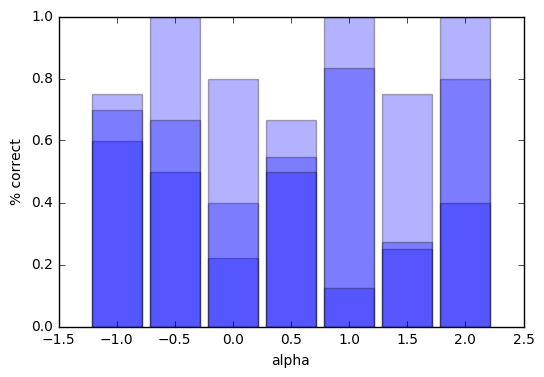

In [10]:
import glob
#from psychopy import misc
import pickle
fig = plt.figure()
ax = fig.add_subplot(111)
for fn in glob.glob('../files/data/discriminating_v2_*pickle'):
    print ('Loading ', fn)
    with open(fn, 'rb') as f: data = pickle.load(f, encoding='latin1')
    print( fn, results.shape)
    print('analyzing results')
    alphas = np.array(data['alphas'])
    print( ' alphas = ', alphas)
    print( '# of trials :', np.abs(data['results']).sum(axis=1))
    print( 'average results: ', (data['results'].sum(axis=1)/np.abs(data['results']).sum(axis=1)*.5+.5))
    width = (alphas.max()-alphas.min())/len(alphas)
    ax.bar(data['alphas'] - width/2, (data['results'].sum(axis=1)/np.abs(data['results']).sum(axis=1)*.5+.5), width=width, alpha=.3 )
#    for i_trial in xrange(data['results'].shape[1]):
#        ax.scatter(data['alphas'][data['results']
ax.set_xlabel('alpha')
ax.set_ylabel('% correct')


In [11]:
# TODO : correct for the number of trials / make global reading / make a new draw of alphas
# TODO : test f_0